# Import Packages

In [2]:
# Importing necessary libraries
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

import traceback
from collections import OrderedDict
from tqdm.auto import tqdm

# Set the random seed for reproducibility
seed = 20230808
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set the device to GPU if available, otherwise use CPU
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# Perform garbage collection and empty the GPU cache in PyTorch
gc.collect()
torch.cuda.empty_cache()


# Model

In [3]:
class NN(nn.Module):
    """
    A simple neural network class.

    Args:
        input_size (int): The number of input features.
        hidden_size (int): The number of hidden units in each hidden layer.
        output_size (int): The number of output features.
        depth (int): The number of hidden layers.
        ac (torch.nn.Module): The activation function to use for each hidden layer.
    """

    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        ac=torch.nn.Tanh,
    ):
        super(NN, self).__init__()

        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, ac()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, input_size).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, output_size).
        """
        return self.layers(x)


# Training Loop

A one-dimensional wave equation is chosen for our experiments, which, in mathematical form, is defined as follows:

$$ u_{tt} - u_{xx} = 0$$

for this wave equation, its initial conditions and the homogeneous Dirichlet boundary conditions are given, as follows:

$$ u(0, x) = \frac{1}{2} \sin (\pi x)$$
$$ u_t(0, x) = \pi \sin (3 \pi x)$$
$$ u(t, 0) =  u(t, 1) = 0 $$

In [3]:
def init_weights(layer):
    """
    Initializes the weights of a layer with Xavier normal initialization.
    Args:
        layer (torch.nn.Module): The layer to initialize.
    """
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_normal_(layer.weight)


class Net:
    def __init__(self):
        self.model = NN(
            input_size=2,
            hidden_size=100,
            output_size=1,
            depth=6,
            act=torch.nn.Tanh
        ).to(device)

        # use the Glorot normal initializer for initialization
        self.model.apply(init_weights)

        # The initial conditions, boundary conditions
        # with Nu approximating 300
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(0, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)
        # x[0] = 0, x[-1] = 1, t[0] = 0
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = 1/2*torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        # Data in the space-time domain
        # with Nf approximating 40000
        self.h = 0.005
        self.k = 0.005
        x = torch.arange(self.h, 1 + self.h, self.h)
        t = torch.arange(self.k, 1 + self.k, self.k)
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

        # Device Consistency
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True

        # Logger
        self.iter = 1

        # Loss Function
        self.criterion = torch.nn.MSELoss()

        # Two Optimizer
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=0.001,
            line_search_fn="strong_wolfe")

        self.adam = torch.optim.Adam(self.model.parameters())

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # loss using observations of initial and boundary conditions
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        # loss based on partial differential equations
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X,
            outputs=u,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]

        du_dxx = torch.autograd.grad(
            inputs=self.X,
            outputs=du_dX,
            grad_outputs=torch.ones_like(du_dX),
            retain_graph=True,
            create_graph=True
        )[0][:, 0]

        du_dtt = torch.autograd.grad(
            inputs=self.X,
            outputs=du_dt,
            grad_outputs=torch.ones_like(du_dt),
            retain_graph=True,
            create_graph=True
        )[0][:, 1]

        loss_pde = self.criterion(du_dtt - du_dxx, torch.zeros(len(du_dxx)))

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss

    def train(self):
        self.model.train()
        # L-BFGS 30,000 epochs
        for _ in range(30000):
            self.optimizer.step(self.loss_func)

        # continued the optimization using Adam
        for _ in tqdm(range(20000)):
            self.adam.step(self.loss_func)

    def eval_(self):
        self.model.eval()


# Training

In [6]:
net = Net()
net.train()


C:\Users\15119\miniconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.08197131007909775
200 0.07749483734369278
300 0.0728987455368042
400 0.0621149055659771
500 0.047411344945430756
600 0.03423658385872841
700 0.01843433454632759
800 0.0144724790006876
900 0.009776297956705093
1000 0.007444297429174185
1100 0.0060519385151565075
1200 0.005530643276870251
1300 0.005319967400282621
1400 0.005056931637227535


  0%|          | 0/1000 [00:00<?, ?it/s]

1500 0.09948475658893585
1600 0.040508586913347244
1700 0.007804663386195898
1800 0.005405857227742672
1900 0.005147742573171854
2000 0.005013446789234877
2100 0.0057419100776314735
2200 0.0048944707959890366
2300 0.004832066595554352
2400 0.004777762573212385
2500 0.03509543836116791
2600 0.0054034022614359856
2700 0.00467543862760067


  0%|          | 0/1000 [00:00<?, ?it/s]

2800 0.03791576623916626
2900 0.0051079061813652515
3000 0.004919388331472874
3100 0.004861308261752129
3200 0.004812697879970074
3300 0.0047675082460045815
3400 0.00472332164645195
3500 0.004679130855947733
3600 0.004634559620171785
3700 0.004593086428940296
3800 0.004671395290642977


  0%|          | 0/1000 [00:00<?, ?it/s]

3900 0.021694306284189224
4000 0.004651131108403206
4100 0.004575787577778101
4200 0.006875512655824423
4300 0.004488170146942139
4400 0.005617693066596985
4500 0.00461021950468421
4600 0.00456671928986907
4700 0.004401106387376785
4800 0.0046903700567781925
4900 0.004488939419388771


  0%|          | 0/1000 [00:00<?, ?it/s]

5000 0.022183608263731003
5100 0.004413342569023371
5200 0.004309519659727812
5300 0.00503583112731576
5400 0.004638551734387875
5500 0.004738910123705864
5600 0.005669400095939636
5700 0.006114127114415169
5800 0.005251163616776466
5900 0.014338873326778412
6000 0.005480404943227768
6100 0.005452136509120464


  0%|          | 0/1000 [00:00<?, ?it/s]

6200 0.004044224973767996
6300 0.005088900215923786
6400 0.00395727064460516
6500 0.004437514580786228
6600 0.0044220564886927605
6700 0.004372825380414724


KeyboardInterrupt: 

In [7]:
torch.save(net.model.state_dict(), 'model.ckpt')


# Evaluation

In [ ]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import plotly.express as px

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use(['ipynb', 'use_mathtext', 'colors5-light', 'science'])
sns.set_style('whitegrid')
sns.set_palette('RdBu')
sns.set(
    rc={'text.usetex': True},
    font='serif',
    font_scale=1.2
)

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.serif'] = ['SimHei']
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})


In [11]:
h = 0.001
k = 0.001
x = torch.arange(0, 1, h)
t = torch.arange(0, 1, k)
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(device)


In [15]:
X.shape


torch.Size([1000000, 2])

In [16]:
def ground_truth(X):
    x = X[:, 0]
    t = X[:, 1]
    y = 1/2*torch.sin(torch.pi*x)*torch.cos(torch.pi*t)+1 / \
        3*torch.sin(3*torch.pi*x)*torch.sin(3*torch.pi*t)
    return y


In [17]:
model = NN(input_size=2,
           hidden_size=100,
           output_size=1,
           depth=6,
           act=torch.nn.Tanh).to(device)
model.load_state_dict(torch.load('model.ckpt'))
model.eval()
with torch.no_grad():
    # y_pred = ground_truth(X).reshape(len(x), len(t)).detach().cpu().numpy()


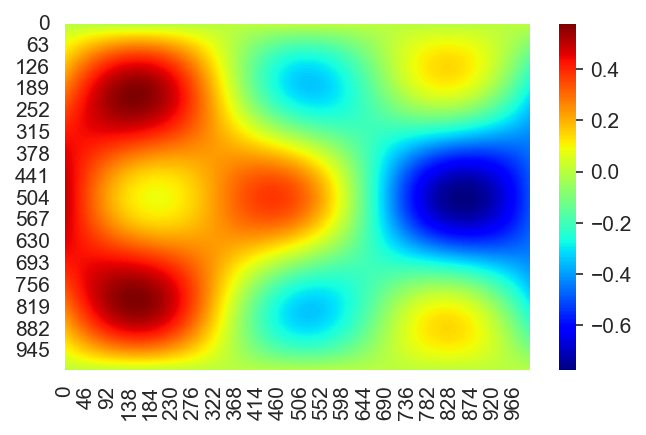

In [47]:
plt.figure(figsize=(5, 3), dpi=150)
sns.heatmap(y_pred, cmap='jet')
plt.show()


In [45]:
x = torch.arange(0, 1, h).unsqueeze(dim=1).to(device)
t = (torch.ones(x.shape)*0.5).to(device)

model(torch.cat([x, t], dim=1)).detach().cpu()


tensor([[-0.2366],
        [-0.2341],
        [-0.2317],
        [-0.2292],
        [-0.2268],
        [-0.2243],
        [-0.2218],
        [-0.2194],
        [-0.2169],
        [-0.2144],
        [-0.2120],
        [-0.2095],
        [-0.2070],
        [-0.2045],
        [-0.2021],
        [-0.1996],
        [-0.1971],
        [-0.1946],
        [-0.1921],
        [-0.1896],
        [-0.1871],
        [-0.1846],
        [-0.1821],
        [-0.1796],
        [-0.1771],
        [-0.1745],
        [-0.1720],
        [-0.1695],
        [-0.1670],
        [-0.1645],
        [-0.1619],
        [-0.1594],
        [-0.1569],
        [-0.1543],
        [-0.1518],
        [-0.1492],
        [-0.1467],
        [-0.1442],
        [-0.1416],
        [-0.1391],
        [-0.1365],
        [-0.1339],
        [-0.1314],
        [-0.1288],
        [-0.1263],
        [-0.1237],
        [-0.1211],
        [-0.1185],
        [-0.1160],
        [-0.1134],
        [-0.1108],
        [-0.1082],
        [-0.

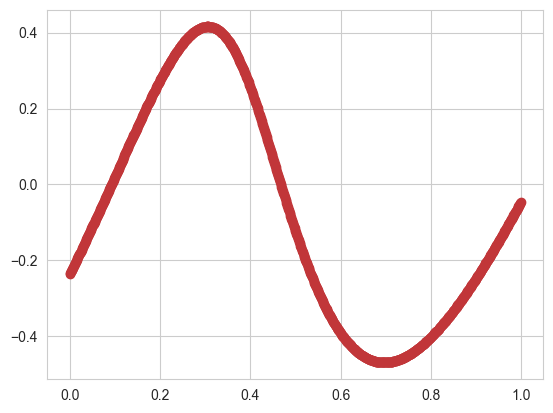

In [46]:
plt.scatter(x.detach().cpu(), model(torch.cat([x, t], dim=1)).detach().cpu())
